# Order returns prediction - binary classification 

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [21]:
from sklearn import preprocessing

In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
import cx_Oracle as orc

## Data import from Oracle

In [8]:
# Make DSN address
dsn = orc.makedsn('hostname', 'port', service_name='servicename')
# Connect to DSN
conn = orc.connect(user='username', password='password', dsn=dsn)

In [9]:
sql_query = """SELECT 
  ORDER_NUMBER,
  (COMPLETED_DATE - CREATION_DATE) AS DELIVERY_DAYS,
  ORDER_METHOD,
  DELIVERY_WAY, 
  CASE 
    WHEN FAMILY_MEMBER IS NOT NULL 
    THEN 'FAMILY'
    ELSE 'NOT FAMILY'
  END AS FAMILY_CUST,
  TOTAL_ORDER_VALUE_NET,
  NUMBER_ARTICLES,
  RETURN_CREAT,
  CASE 
    WHEN PUR_PROOF IS NOT NULL 
    THEN 'RETURNED'
    ELSE 'NOT RETURNED'
  END AS ORDER_STATUS
FROM 
( 
SELECT 
  ORDER_NUMBER,
  TRUNC(CREATION_DATE) AS CREATION_DATE,
  TRUNC(COMPLETED_DATE) AS COMPLETED_DATE,
  ORDER_METHOD,
  DELIVERY_WAY,
  FAMILY_MEMBER,
  TOTAL_ORDER_VALUE_NET,
  NUMBER_ARTICLES
FROM 
  "PRD_ODI_AWE"."MASTER_SALES_FACT"
WHERE 
  COMPLETED_DATE IS NOT NULL AND
  DELIVERY_WAY NOT IN ('CLICK&COLLECT', 'EXPRESS DELIVERY') AND
  CREATION_DATE >= TO_DATE('01.09.18','DD.MM.YY')) a 
LEFT JOIN 
( 
SELECT 
  MIN(RETURN_CREAT_DT) AS RETURN_CREAT,
  MIN(RETURN_COMPL_DT) AS RETURN_COMPL,
  PUR_PROOF 
FROM  
  "PRD_ODI_AWE"."RETURN_FT"
WHERE 
  SELLING_STO_ID = 52 AND
  RETURN_CREAT_DT >= TO_DATE('01.09.18','DD.MM.YY') AND
  PUR_PROOF IS NOT NULL 
GROUP BY
  PUR_PROOF) b
ON 
  a.ORDER_NUMBER = b.PUR_PROOF
WHERE 
  CREATION_DATE IS NOT NULL AND
  CREATION_DATE >= TO_DATE('01.09.18','DD.MM.YY')"""

In [7]:
original_df = pd.read_sql(sql_query, conn)

In [10]:
df_a1 = original_df.copy()

In [11]:
sql_query2 = """SELECT 
  t1.SO_NO AS ORDER_NUMBER, 
  t5.HFB_NO, 
  t5.HFB_NAME
FROM  
  PRD_ODI_AWE.DIG_ODS_IDSS_CRE_SO_SALE_FT t1
INNER JOIN 
  PRD_ODI_AWE.ITEM_DT t2 ON t1.ITEM_ID = t2.ITEM_ID
INNER JOIN 
  PRD_ODI_AWE.PA_DT t3 ON t2.PA_ID = t3.PA_ID
INNER JOIN 
  PRD_ODI_AWE.PRA_DT t4 ON t3.PRA_ID = t4.PRA_ID
INNER JOIN 
  PRD_ODI_AWE.HFB_DT t5 ON t4.HFB_ID = t5.HFB_ID
WHERE 
  t2.CUR_IND = 'Y' AND 
  t3.CUR_IND = 'Y' AND 
  t4.CUR_IND = 'Y' AND 
  t5.CUR_IND = 'Y' AND
  t1.SO_CREAT_DTM >= TO_DATE('01.09.18','DD.MM.YY') AND
  t1.STO_ID = 52 AND
  t1.SO_COMPL_DTM IS NOT NULL"""

In [12]:
original_item_df = pd.read_sql(sql_query2, conn)

In [13]:
item_df1 = original_item_df.copy()

## Data exploration

In [14]:
df_a1.head()

,ORDER_NUMBER,DELIVERY_DAYS,ORDER_METHOD,DELIVERY_WAY,FAMILY_CUST,TOTAL_ORDER_VALUE_NET,NUMBER_ARTICLES,RETURN_CREAT,ORDER_STATUS
0,1001221780,9,INTERNET,PARCEL,FAMILY,46.73,10.0,NaT,NOT RETURNED
1,1016958255,9,INTERNET,PARCEL,FAMILY,21.29,7.0,NaT,NOT RETURNED
2,1027034568,5,INTERNET,PARCEL,NOT FAMILY,90.61,8.0,2019-04-27 13:13:12,RETURNED
3,1023791192,5,INTERNET,PARCEL,FAMILY,52.86,13.0,NaT,NOT RETURNED
4,1021575410,6,INTERNET,PARCEL,NOT FAMILY,25.95,2.0,NaT,NOT RETURNED


In [ ]:
df_a1.info()

In [ ]:
pd.set_option('display.float_format','{:.2f}'.format)
df_a1.describe(include='all')

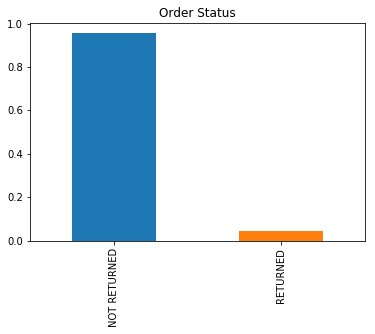

In [17]:
df_a1['ORDER_STATUS'].value_counts(normalize=True).plot.bar(title='Order Status')

In [ ]:
df_a1['ORDER_STATUS'].value_counts(normalize=True)

In [ ]:
df_a1['ORDER_STATUS'].value_counts()

In [ ]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(321)
pd.crosstab(df_a1['FAMILY_CUST'], df_a1['ORDER_STATUS'], normalize='index').plot.barh(stacked=True, ax=ax1, legend=False)
ax2 = fig.add_subplot(322)
pd.crosstab(df_a1['ORDER_METHOD'], df_a1['ORDER_STATUS'], normalize='index').plot.barh(stacked=True, ax=ax2, legend=False)
ax4 = fig.add_subplot(323)
pd.crosstab(df_a1['DELIVERY_WAY'], df_a1['ORDER_STATUS'], normalize='index').plot.barh(stacked=True, ax=ax4, legend=False)
plt.show()

In [24]:
le = preprocessing.LabelEncoder()
df_a1['ORDER_STATUS'] = le.fit_transform(df_a1['ORDER_STATUS'])
df_a1.head()

,ORDER_NUMBER,DELIVERY_DAYS,ORDER_METHOD,DELIVERY_WAY,FAMILY_CUST,TOTAL_ORDER_VALUE_NET,NUMBER_ARTICLES,RETURN_CREAT,ORDER_STATUS
0,1001221780,9,INTERNET,PARCEL,FAMILY,46.73,10.00,NaT,0
1,1016958255,9,INTERNET,PARCEL,FAMILY,21.29,7.00,NaT,0
2,1027034568,5,INTERNET,PARCEL,NOT FAMILY,90.61,8.00,2019-04-27 13:13:12,1
3,1023791192,5,INTERNET,PARCEL,FAMILY,52.86,13.00,NaT,0
4,1021575410,6,INTERNET,PARCEL,NOT FAMILY,25.95,2.00,NaT,0


In [ ]:
df_a1.info()

In [ ]:
df_a1.corr(method='spearman')

## Handling missing values

In [22]:
df_a1.isnull().sum()

ORDER_NUMBER                   0
DELIVERY_DAYS                  0
ORDER_METHOD                   0
DELIVERY_WAY                   0
FAMILY_CUST                    0
TOTAL_ORDER_VALUE_NET         32
NUMBER_ARTICLES             2696
RETURN_CREAT             3061918
ORDER_STATUS                   0
dtype: int64

In [23]:
df_a2 = df_a1.drop(['RETURN_CREAT'], axis=1)

In [24]:
df_a2['TOTAL_ORDER_VALUE_NET'].fillna(df_a2['TOTAL_ORDER_VALUE_NET'].median(), inplace=True)
df_a2['NUMBER_ARTICLES'].fillna(df_a2['NUMBER_ARTICLES'].median(), inplace=True)

In [25]:
df_a2.isnull().sum()

ORDER_NUMBER             0
DELIVERY_DAYS            0
ORDER_METHOD             0
DELIVERY_WAY             0
FAMILY_CUST              0
TOTAL_ORDER_VALUE_NET    0
NUMBER_ARTICLES          0
ORDER_STATUS             0
dtype: int64

## Outliers treatment

In [ ]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221)
sns.distplot(df_a2['DELIVERY_DAYS'], hist=True, ax=ax1)
ax2 = fig.add_subplot(222)
sns.distplot(df_a2['TOTAL_ORDER_VALUE_NET'], hist=True, ax=ax2)
ax3 = fig.add_subplot(223)
sns.distplot(df_a2['NUMBER_ARTICLES'], hist=True, ax=ax3)
plt.show()

In [24]:
len(df_a2[df_a2['NUMBER_ARTICLES']>100])

13609

In [25]:
len(df_a2[df_a2['DELIVERY_DAYS']>50])

14673

In [26]:
len(df_a2[df_a2['TOTAL_ORDER_VALUE_NET']>2100])

14510

In [26]:
len(df_a2[(df_a2['NUMBER_ARTICLES']>100) | (df_a2['DELIVERY_DAYS']>50) | (df_a2['TOTAL_ORDER_VALUE_NET']>2100)])

38207

In [27]:
df_a3 = df_a2.copy()

In [28]:
df_a3['NUMBER_ARTICLES'] = df_a3['NUMBER_ARTICLES'].clip(0, 100)

In [29]:
df_a3['DELIVERY_DAYS'] = df_a3['DELIVERY_DAYS'].clip(0, 50)

In [30]:
df_a3['TOTAL_ORDER_VALUE_NET'] = df_a3['TOTAL_ORDER_VALUE_NET'].clip(0, 2100)

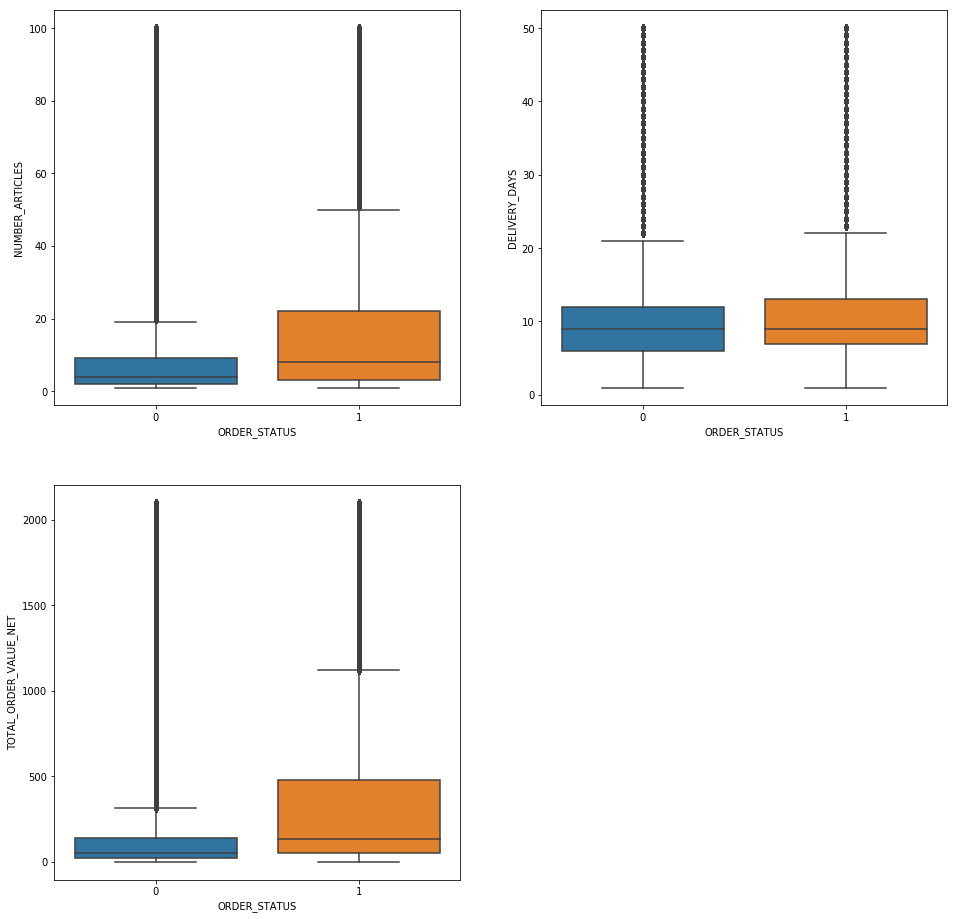

In [32]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221)
sns.boxplot(x=df_a3['ORDER_STATUS'], y=df_a3['NUMBER_ARTICLES'], ax=ax1)
ax2 = fig.add_subplot(222)
sns.boxplot(x=df_a3['ORDER_STATUS'], y=df_a3['DELIVERY_DAYS'], ax=ax2)
ax3 = fig.add_subplot(223)
sns.boxplot(x=df_a3['ORDER_STATUS'], y=df_a3['TOTAL_ORDER_VALUE_NET'], ax=ax3)
plt.show()

In [31]:
df_a3.head()

,ORDER_NUMBER,DELIVERY_DAYS,ORDER_METHOD,DELIVERY_WAY,FAMILY_CUST,TOTAL_ORDER_VALUE_NET,NUMBER_ARTICLES,ORDER_STATUS
0,1052627295,37,INTERNET,PARCEL,NOT FAMILY,22.59,2.0,0
1,1051968556,5,INTERNET,TRUCK,FAMILY,242.02,4.0,0
2,1052039863,12,INTERNET,PARCEL,NOT FAMILY,108.32,1.0,0
3,1052056126,14,INTERNET,PARCEL,NOT FAMILY,37.71,3.0,0
4,1048719337,18,INTERNET,MIXED ORDER,NOT FAMILY,662.56,60.0,1


## Sampling of dataset

In [32]:
#downsampling for outliers limited dataframe
shuffled_df1 = df_a3.sample(frac=1, random_state=1000)
df_majority1 = shuffled_df1.loc[shuffled_df1['ORDER_STATUS']==0].sample(n=700000, random_state=1000)
df_minority1 = shuffled_df1.loc[shuffled_df1['ORDER_STATUS']==1]
df_downsampled1 = pd.concat([df_majority1, df_minority1])
df_downsampled1 = df_downsampled1.sample(frac=1, random_state=1000)
df_downsampled1['ORDER_STATUS'].value_counts()

0    700000
1    134682
Name: ORDER_STATUS, dtype: int64

In [33]:
df_a4 = df_downsampled1.copy()

In [ ]:
df_a4.info()

### Joining with Item level dataset

In [25]:
item_df1.head(10)

,ORDER_NUMBER,HFB_NO,HFB_NAME
0,689293298,02,Store and organise furniture
1,1003961275,97,Services
2,1003961275,04,Bedroom furniture
3,1003961275,18,Home organisation
4,1003961275,04,Bedroom furniture
5,1003961275,04,Bedroom furniture
6,1003961369,02,Store and organise furniture
7,1003961369,02,Store and organise furniture
8,1003961369,02,Store and organise furniture
9,1003961369,02,Store and organise furniture


In [13]:
item_df1.isnull().sum()

ORDER_NUMBER    0
HFB_NO          0
HFB_NAME        0
dtype: int64

In [15]:
item_df2 = item_df1.drop(['HFB_NAME'], axis=1)

In [16]:
item_df3 = pd.get_dummies(item_df2, prefix=['HFB_NO'])

In [26]:
item_df3.head(10)

,ORDER_NUMBER,HFB_NO_01,HFB_NO_02,HFB_NO_03,HFB_NO_04,HFB_NO_05,HFB_NO_06,HFB_NO_07,HFB_NO_08,HFB_NO_09,...,HFB_NO_15,HFB_NO_16,HFB_NO_17,HFB_NO_18,HFB_NO_20,HFB_NO_70,HFB_NO_95,HFB_NO_96,HFB_NO_97,HFB_NO_?
0,689293298,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1003961275,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1003961275,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1003961275,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1003961275,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1003961275,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1003961369,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1003961369,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1003961369,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1003961369,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
item_df4 = item_df3.groupby(['ORDER_NUMBER'])['HFB_NO_01', 'HFB_NO_02', 'HFB_NO_03', 'HFB_NO_04', 'HFB_NO_05', 'HFB_NO_06', 'HFB_NO_07', 'HFB_NO_08',
                                             'HFB_NO_09', 'HFB_NO_10', 'HFB_NO_11', 'HFB_NO_12', 'HFB_NO_13', 'HFB_NO_14', 'HFB_NO_15', 'HFB_NO_16',
                                             'HFB_NO_17', 'HFB_NO_18',  'HFB_NO_20', 'HFB_NO_70', 'HFB_NO_95', 'HFB_NO_96', 'HFB_NO_97'].apply(lambda x: x.max())

In [ ]:
item_df4.head()

In [44]:
df_a5 = pd.merge(df_a4, item_df4, on='ORDER_NUMBER', how='left')

In [45]:
df_a5.head()

,ORDER_NUMBER,DELIVERY_DAYS,ORDER_METHOD,DELIVERY_WAY,FAMILY_CUST,TOTAL_ORDER_VALUE_NET,NUMBER_ARTICLES,ORDER_STATUS,HFB_NO_01,HFB_NO_02,...,HFB_NO_14,HFB_NO_15,HFB_NO_16,HFB_NO_17,HFB_NO_18,HFB_NO_20,HFB_NO_70,HFB_NO_95,HFB_NO_96,HFB_NO_97
0,1010507090,11,INTERNET,PARCEL,NOT FAMILY,19.20,5.0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
1,1001931606,9,INTERNET,PARCEL,NOT FAMILY,51.18,18.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1014350764,16,INTERNET,TRUCK,NOT FAMILY,860.51,34.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1014505275,9,INTERNET,PARCEL,NOT FAMILY,35.50,31.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,1052973957,11,INTERNET,MIXED ORDER,NOT FAMILY,248.73,3.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


## Building the classifier model 

In [35]:
X = df_a4.drop(['ORDER_STATUS', 'ORDER_NUMBER', 'ORDER_METHOD'], axis=1)
y = df_a4.ORDER_STATUS

In [36]:
X = pd.get_dummies(X)

In [ ]:
X.head()

In [ ]:
X.info()

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

In [40]:
model_features = list(X_train.columns)

### Scaler transformation 

In [41]:
sc = StandardScaler()

In [42]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# Logistics classifier
C = [0.1, 0.5]
for c in C:
    print('C value is: ' + str(c))
    model = LogisticRegression(C=c, penalty='l1')
    model.fit(X_train, y_train)
    print('Features importance: ')
    for feature in zip(model_features, model.coef_[0]):
        print(feature)
    pred_test = model.predict(X_test)
    print('Accuracy score: ' + str(accuracy_score(y_test, pred_test)))
    print(confusion_matrix(y_test, pred_test))
    print(classification_report(y_test, pred_test))

In [145]:
# Examples for false negatives
df_fn = X_test[(y_test == 1) & (pred_test.T == 0)]
df_fn.head()

,DELIVERY_DAYS,DELIVERY_CHARGE,TOTAL_ORDER_VALUE_NET,NUMBER_ARTICLES,CREATION_MONTH,CREATION_YEAR,COMPLETED_MONTH,COMPLETED_YEAR,ORDER_METHOD_INTERNET,ORDER_METHOD_LETTER,ORDER_METHOD_PHONE,ORDER_METHOD_STORE,ORDER_METHOD_TELANSMACH,DELIVERY_WAY_MIXED ORDER,DELIVERY_WAY_PARCEL,DELIVERY_WAY_TRUCK,FAMILY_CUST_FAMILY,FAMILY_CUST_NOT FAMILY,CUSTOMER_TYPE_BUSINESS,CUSTOMER_TYPE_PRIVATE
1256189,10,7.00,172.98,6.00,5,2019,6,2019,1,0,0,0,0,0,1,0,0,1,0,1
396086,10,99.00,652.10,47.00,2,2019,3,2019,1,0,0,0,0,0,0,1,1,0,0,1
1558019,6,3.90,104.10,2.00,3,2019,3,2019,1,0,0,0,0,0,1,0,1,0,0,1
944414,5,4.00,65.39,8.00,7,2019,7,2019,1,0,0,0,0,0,1,0,0,1,0,1
1137198,8,3.90,168.78,6.00,5,2019,5,2019,1,0,0,0,0,0,1,0,0,1,0,1


In [146]:
# Examples for false positives
df_fp = X_test[(y_test == 0) & (pred_test.T == 1)]
df_fp.head()

,DELIVERY_DAYS,DELIVERY_CHARGE,TOTAL_ORDER_VALUE_NET,NUMBER_ARTICLES,CREATION_MONTH,CREATION_YEAR,COMPLETED_MONTH,COMPLETED_YEAR,ORDER_METHOD_INTERNET,ORDER_METHOD_LETTER,ORDER_METHOD_PHONE,ORDER_METHOD_STORE,ORDER_METHOD_TELANSMACH,DELIVERY_WAY_MIXED ORDER,DELIVERY_WAY_PARCEL,DELIVERY_WAY_TRUCK,FAMILY_CUST_FAMILY,FAMILY_CUST_NOT FAMILY,CUSTOMER_TYPE_BUSINESS,CUSTOMER_TYPE_PRIVATE
2057054,31,0.00,1946.98,85.00,6,2019,7,2019,1,0,0,0,0,1,0,0,0,1,0,1
2901234,16,175.00,1508.24,31.00,9,2018,10,2018,1,0,0,0,0,0,0,1,1,0,0,1
2245002,13,175.00,1540.34,57.00,11,2018,11,2018,1,0,0,0,0,0,0,1,0,1,0,1
2301615,10,175.00,1862.16,54.00,4,2019,4,2019,1,0,0,0,0,0,0,1,0,1,0,1
717556,26,75.00,516.32,94.00,3,2019,3,2019,1,0,0,0,0,0,0,1,1,0,0,1


In [55]:
# Naive Bayes classifier - GaussianNB
model2 = GaussianNB() 

In [56]:
model2.fit(X_train, y_train)

GaussianNB(priors=None)

In [57]:
pred_test2 = model2.predict(X_test)

In [ ]:
print('Accuracy score: ' + str(accuracy_score(y_test, pred_test2)))

In [ ]:
confusion_matrix(y_test, pred_test2)

In [ ]:
print(classification_report(y_test, pred_test2))

In [61]:
# Naive Bayes classifier - BernoulliNB
model5 = BernoulliNB() 

In [62]:
model5.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
pred_test5 = model5.predict(X_test)

In [ ]:
print('Accuracy score: ' + str(accuracy_score(y_test, pred_test5)))

In [ ]:
confusion_matrix(y_test, pred_test5)

In [63]:
print(classification_report(y_test, pred_test5))

In [206]:
# Decision trees classifier
model8 = DecisionTreeClassifier(max_depth=8) 

In [207]:
model8.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [208]:
pred_test8 = model8.predict(X_test)

In [ ]:
print('Accuracy score: ' + str(accuracy_score(y_test, pred_test8)))

In [ ]:
confusion_matrix(y_test, pred_test8)

In [ ]:
print(classification_report(y_test, pred_test8))

### Voting classifer - hard voting

In [62]:
modelx = VotingClassifier(estimators = [('logistic',LogisticRegression()),
                            ('dectree', DecisionTreeClassifier(max_depth=8)),
                            ('bern',BernoulliNB())], voting='hard')

In [63]:
modelx.fit(X_train, y_train)

VotingClassifier(estimators=[('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('dectre...splitter='best')), ('bern', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [64]:
pred_testx = modelx.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
print('Accuracy score: ' + str(accuracy_score(y_test, pred_testx)))

In [ ]:
confusion_matrix(y_test, pred_testx)

In [ ]:
print(classification_report(y_test, pred_testx))